# CAS Project

# 1. Introduction

The goal of this project was to be able to predict different fruit via a model and to compare different algorithms, random forest, CNN and transfer learning. As a side fun goal i wanted to be able to reload a model and use the webcam to take an image of various fruit / veg, identify them then send them off to openai to generate a recipe.


### Library imports
just loading all the libraries needed for the project and mlflow


In [22]:
# Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import os
import random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
import warnings
#import mlflow
#import mlflow.sklearn
#import mlflow.pyfunc



# tensor flow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score


### Setup constants for directories
The original data set was found on kaggle. Unfortunately we did not initially realise that the dataset had the validation set identical to the test set and much worse that, all the images in the test set were actually in the test data as well. 
I realised this when looking at the images within the test and validation, but it wasn't obvious. When we first ran the models we also had stunning results of 97% for random forest and more for the basic CNN. It was only on running an extra set of - that resulted in only 43% that I realised something was wrong. Finding that the train / validation were in the training set seemed a good hypothesis I wrote a hash function to find duplicates. 
This is included in the remove duplicates functions in a separate notebook. 
In addition, the categories of sweetcorn and corn were the same as well as bell pepper and capsicum. I manually removed these from the dataset.
This notebook is running after the remove duplicates and recreating 10 random images being re-added to the validation and test sets. 



In [23]:

OUTPUT_DIR = '/Users/alexchilton/Downloads/working/'

DIR_REAL_TRAIN = '/Users/alexchilton/Downloads/working/train'
DIR_REAL_TEST = '/Users/alexchilton/Downloads/working/test'
DIR_REAL_VALIDATION = '/Users/alexchilton/Downloads/working/validation'

MODEL_LOCATION = '/Users/alexchilton/Downloads/working/best_model.keras'

### Helper fucntions
Just some helper functions which are used for file loading and displaying images and counting the number of images in each class.


In [24]:
# Define a function to get the true label from the image path
def get_true_label(img_path):
    """ Get the true label from the image path """
    return os.path.basename(os.path.dirname(img_path))

def count_samples_per_class(y, label_encoder):
    """ Count the number of samples per class """
    unique_classes, counts = np.unique(y, return_counts=True)
    class_counts = {label_encoder.inverse_transform([cls])[0]: count for cls, count in zip(unique_classes, counts)}
    return class_counts

# Update the load_images_from_folders function to return filenames
def load_images_from_folders(folders, image_size=(128, 128), exclude_classes=None, grayscale=False):
    """ Load images from a list of folders and return the images and labels """
    if exclude_classes is None:
        exclude_classes = []
    images = []
    labels = []
    filenames = []
    for folder in folders:
        for class_name in os.listdir(folder):
            if class_name in exclude_classes:
                continue
            class_folder = os.path.join(folder, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, filename)
                    img = Image.open(img_path)
                    if grayscale:
                        img = img.convert('L')  # Convert to grayscale
                        img = img.resize(image_size)  # Resize image to the specified size
                        img_array = np.array(img)
                        img_array = img_array[:, :, np.newaxis]  # Add channel dimension
                    else:
                        img = img.resize(image_size)  # Resize image to the specified size
                        img_array = np.array(img)
                        if img_array.shape == (image_size[0], image_size[1], 4):  # Check for RGBA images
                            img_array = img_array[:, :, :3]  # Discard the alpha channel
                        if img_array.shape != (image_size[0], image_size[1], 3):  # Ensure the image is RGB
                            print(f"Skipping image {img_path} due to incorrect shape: {img_array.shape}")
                            continue
                    img_array = img_array.flatten()  # Flatten the image
                    images.append(img_array)
                    labels.append(f"{class_name}")
                    filenames.append(img_path)  # Store the full path of the image

    return np.array(images), np.array(labels), filenames

# Load and preprocess the images
def load_and_preprocess_image(img_path):
    """ Load and preprocess an image from the specified path """
    img = image.load_img(img_path, target_size=(128, 128))  # Resize image to 128x128
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

def show_random_images(path = DIR_REAL_TRAIN, num_images=16):
    """ Display a grid of random images from the specified directory """
    # Define the path to your test directory
    vis_dir = path

    # Get the list of all subdirectories (classes)
    classes = os.listdir(vis_dir)

    # Initialize an empty list to store file paths
    image_paths = []

    # Loop through each class folder and collect a few image paths
    for cls in classes:
        class_dir = os.path.join(vis_dir, cls)
        images = os.listdir(class_dir)
        for img in images:
            image_paths.append(os.path.join(class_dir, img))

    # Randomly select 16 images from the test set
    random_images = random.sample(image_paths, num_images)
    # Set up a 4x4 grid for plotting
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    # Loop through the grid and add an image to each subplot
    for i, ax in enumerate(axes.flat):
        img = mpimg.imread(random_images[i])
        ax.imshow(img)
        ax.set_title(get_true_label(random_images[i]))
        ax.axis('off')  # Hide axes

    # Display the plot
    plt.show()

def show_number_in_class(path = DIR_REAL_TRAIN, strType = 'Training', strColor = 'skyblue'):
    """ Display a bar plot of the number of images in each class """
    # Get the list of all subdirectories (classes)
    classes = os.listdir(path)

    # Count the number of images in each class
    image_count = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes}

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(image_count.keys(), image_count.values(), color=strColor)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class in the ' + strType + ' Data')
    plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
    plt.show()

def resize_and_save_image(input_path, output_path, size=(128, 128)):
    """ Resize an image and save it to the specified path """
    try:
        with Image.open(input_path) as img:
            # Handle images with Transparency in Palette mode
            if img.mode == 'P':
                img = img.convert('RGBA')
            # Convert image to RGB if it has an alpha channel or is Palette based
            if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                img = img.convert('RGB')
            img = img.resize(size, Image.LANCZOS)
            img.save(output_path, format='JPEG')
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

def load_images_from_folder(folder, image_size=(128, 128), exclude_classes=None, grayscale=False): #is possible to work with greyscale or rgb
    """ Load images from a folder and return the images and labels """
    if exclude_classes is None: # left in for possible future use, not actually used
        exclude_classes = []
    images = []
    labels = []
    filenames = []
    for class_name in os.listdir(folder):
        if class_name in exclude_classes:
            continue
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path)
                if grayscale:
                    img = img.convert('L')  # Convert to grayscale
                    img = img.resize(image_size)  # Resize image to the specified size
                    img_array = np.array(img)
                    img_array = img_array[:, :, np.newaxis]  # Add channel dimension
                else:
                    img = img.resize(image_size)  # Resize image to the specified size
                    img_array = np.array(img)
                    if img_array.shape == (image_size[0], image_size[1], 4):  # Check for RGBA images
                        img_array = img_array[:, :, :3]  # Discard the alpha channel
                    if img_array.shape != (image_size[0], image_size[1], 3):  # Ensure the image is RGB
                        print(f"Skipping image {img_path} due to incorrect shape: {img_array.shape}")
                        continue
                img_array = img_array.flatten()  # Flatten the image
                images.append(img_array)
                labels.append(class_name)
                filenames.append(filename)
    return np.array(images), np.array(labels), filenames

# Update the print_misclassified_samples function to include filenames
def print_misclassified_samples(X, y_true, y_pred, misclassified_indices, filenames, title, grayscale=False):
    """ Print the first 16 misclassified samples """
    print(f"{title} - Misclassified Samples:")
    for index in misclassified_indices[:16]:  # Limit to the first 16 misclassified samples
        print(f"Index: {index}, Filename: {filenames[index]}, Predicted: {y_pred[index]}, Actual: {y_true[index]}")

    num_images = min(16, len(misclassified_indices))  # Ensure we don't exceed the number of misclassified samples
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for ax, index in zip(axes, misclassified_indices[:num_images]):
        if grayscale:
            img = X[index].reshape(128, 128, 1)
            ax.imshow(img, cmap='gray')
        else:
            img = X[index].reshape(128, 128, 3)
            ax.imshow(img)
        ax.set_title(f"Pred: {y_pred[index]}, Act: {y_true[index]}\nPath: {filenames[index]}")
        ax.axis('off')

    # Hide any remaining empty subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
def process_directory(input_directory, output_directory):
    """ Process all images in a directory and save them to the output directory """
    for root, dirs, files in os.walk(input_directory):
        # Create the corresponding directory structure in the output directory
        relative_path = os.path.relpath(root, input_directory)
        output_path = os.path.join(output_directory, relative_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        # Process each image file
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_file_path = os.path.join(root, file_name)
                output_file_path = os.path.join(output_path, file_name)
                resize_and_save_image(input_file_path, output_file_path)



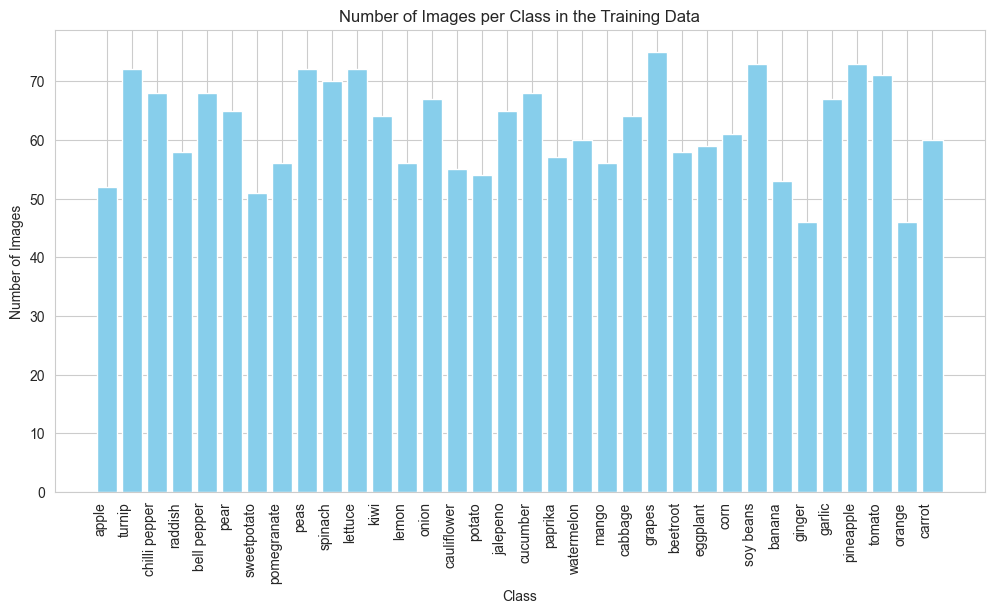

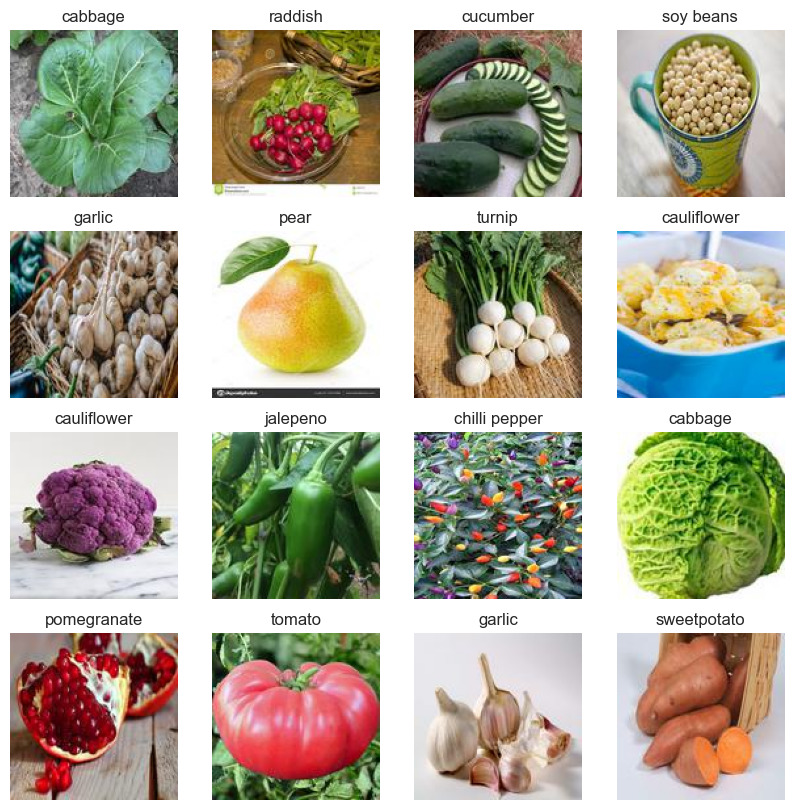

In [37]:
show_number_in_class(DIR_REAL_TRAIN, 'Training', 'skyblue')
show_random_images(DIR_REAL_TRAIN, 16)


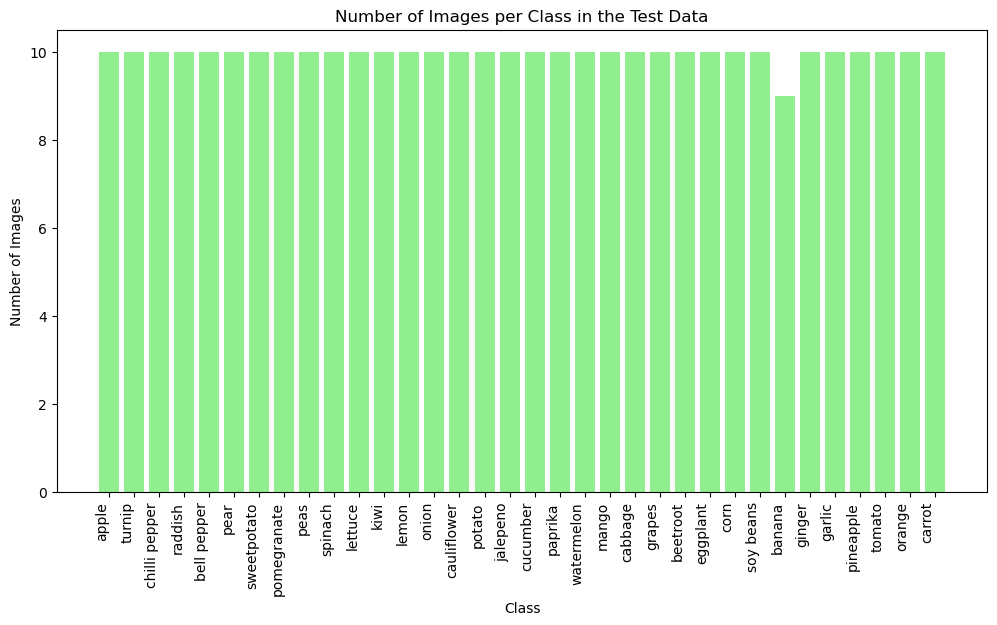

In [5]:
show_number_in_class(DIR_REAL_TEST, 'Test', 'lightgreen')

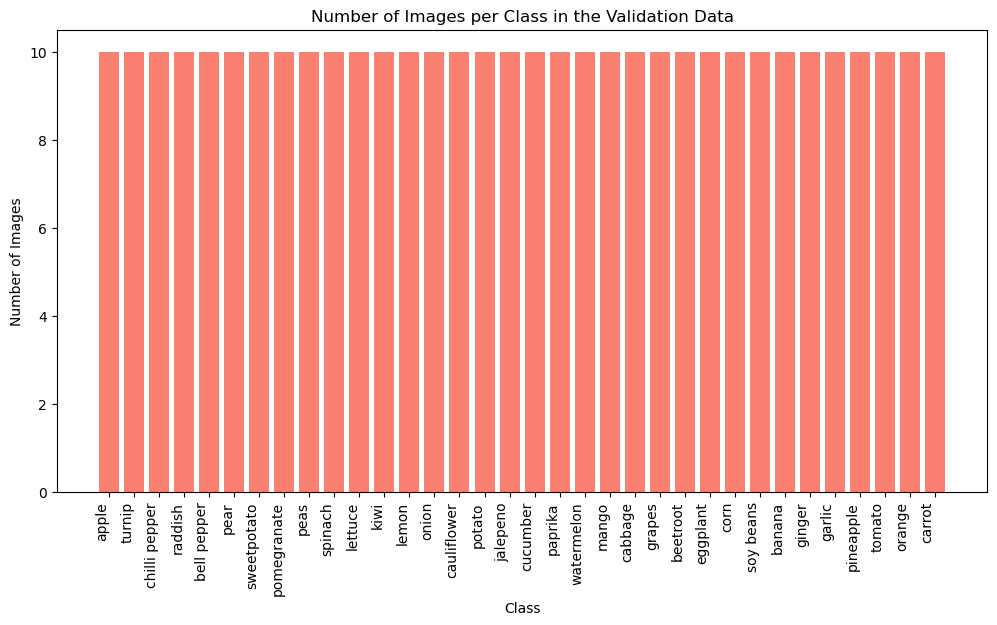

In [6]:
show_number_in_class(DIR_REAL_VALIDATION, 'Validation', 'salmon')

The datasets are as shown relatively balanced for the training and the test and validation sets have basically equal numbers.


### Random Forest - as a first attempt we decided to try a random forest model. As a good first model for comparison

 

In [7]:
exclude_classes = []

def train_and_evaluate(clf, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    """ Train and evaluate a classifier """
    print("Training set class counts:")
    print(count_samples_per_class(y_train, label_encoder))

    print("Validation set class counts:")
    print(count_samples_per_class(y_val, label_encoder))

    print("Test set class counts:")
    print(count_samples_per_class(y_test, label_encoder))

    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy: {val_accuracy}')

    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy: {test_accuracy}')

    misclassified_indices_val = np.where(y_val != y_val_pred)[0]
    misclassified_indices_test = np.where(y_test != y_test_pred)[0]

    return val_accuracy, test_accuracy, misclassified_indices_val, misclassified_indices_test

# Load datasets in grayscale
X_train_gray, y_train_gray, filenames_train_gray = load_images_from_folder(DIR_REAL_TRAIN, exclude_classes=exclude_classes, grayscale=True)
X_test_gray, y_test_gray, filenames_test_gray = load_images_from_folder(DIR_REAL_TEST, exclude_classes=exclude_classes, grayscale=True)
X_val_gray, y_val_gray, filenames_val_gray = load_images_from_folder(DIR_REAL_VALIDATION, exclude_classes=exclude_classes, grayscale=True)

# Load datasets in RGB
X_train_rgb, y_train_rgb, filenames_train_rgb = load_images_from_folder(DIR_REAL_TRAIN, exclude_classes=exclude_classes, grayscale=False)
X_test_rgb, y_test_rgb, filenames_test_rgb = load_images_from_folder(DIR_REAL_TEST, exclude_classes=exclude_classes, grayscale=False)
X_val_rgb, y_val_rgb, filenames_val_rgb = load_images_from_folder(DIR_REAL_VALIDATION, exclude_classes=exclude_classes, grayscale=False)

# Normalize the image data to [0, 1]
X_train_rgb = X_train_rgb / 255.0
X_test_rgb = X_test_rgb / 255.0
X_val_rgb = X_val_rgb / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_train_rgb_encoded = label_encoder.fit_transform(y_train_rgb)
y_test_rgb_encoded = label_encoder.transform(y_test_rgb)
y_val_rgb_encoded = label_encoder.transform(y_val_rgb)

# Initialize classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)


42

RGB Results:
Random Forest:
Training set class counts:
{'apple': 52, 'banana': 53, 'beetroot': 58, 'bell pepper': 68, 'cabbage': 64, 'carrot': 60, 'cauliflower': 55, 'chilli pepper': 68, 'corn': 61, 'cucumber': 68, 'eggplant': 59, 'garlic': 67, 'ginger': 46, 'grapes': 75, 'jalepeno': 65, 'kiwi': 64, 'lemon': 56, 'lettuce': 72, 'mango': 56, 'onion': 67, 'orange': 46, 'paprika': 57, 'pear': 65, 'peas': 72, 'pineapple': 73, 'pomegranate': 56, 'potato': 54, 'raddish': 58, 'soy beans': 73, 'spinach': 70, 'sweetpotato': 51, 'tomato': 71, 'turnip': 72, 'watermelon': 60}
Validation set class counts:
{'apple': 10, 'banana': 10, 'beetroot': 10, 'bell pepper': 10, 'cabbage': 10, 'carrot': 10, 'cauliflower': 10, 'chilli pepper': 10, 'corn': 10, 'cucumber': 10, 'eggplant': 10, 'garlic': 10, 'ginger': 10, 'grapes': 10, 'jalepeno': 10, 'kiwi': 10, 'lemon': 10, 'lettuce': 10, 'mango': 10, 'onion': 10, 'orange': 10, 'paprika': 10, 'pear': 10, 'peas': 10, 'pineapple': 10, 'pomegranate': 10, 'potato': 10

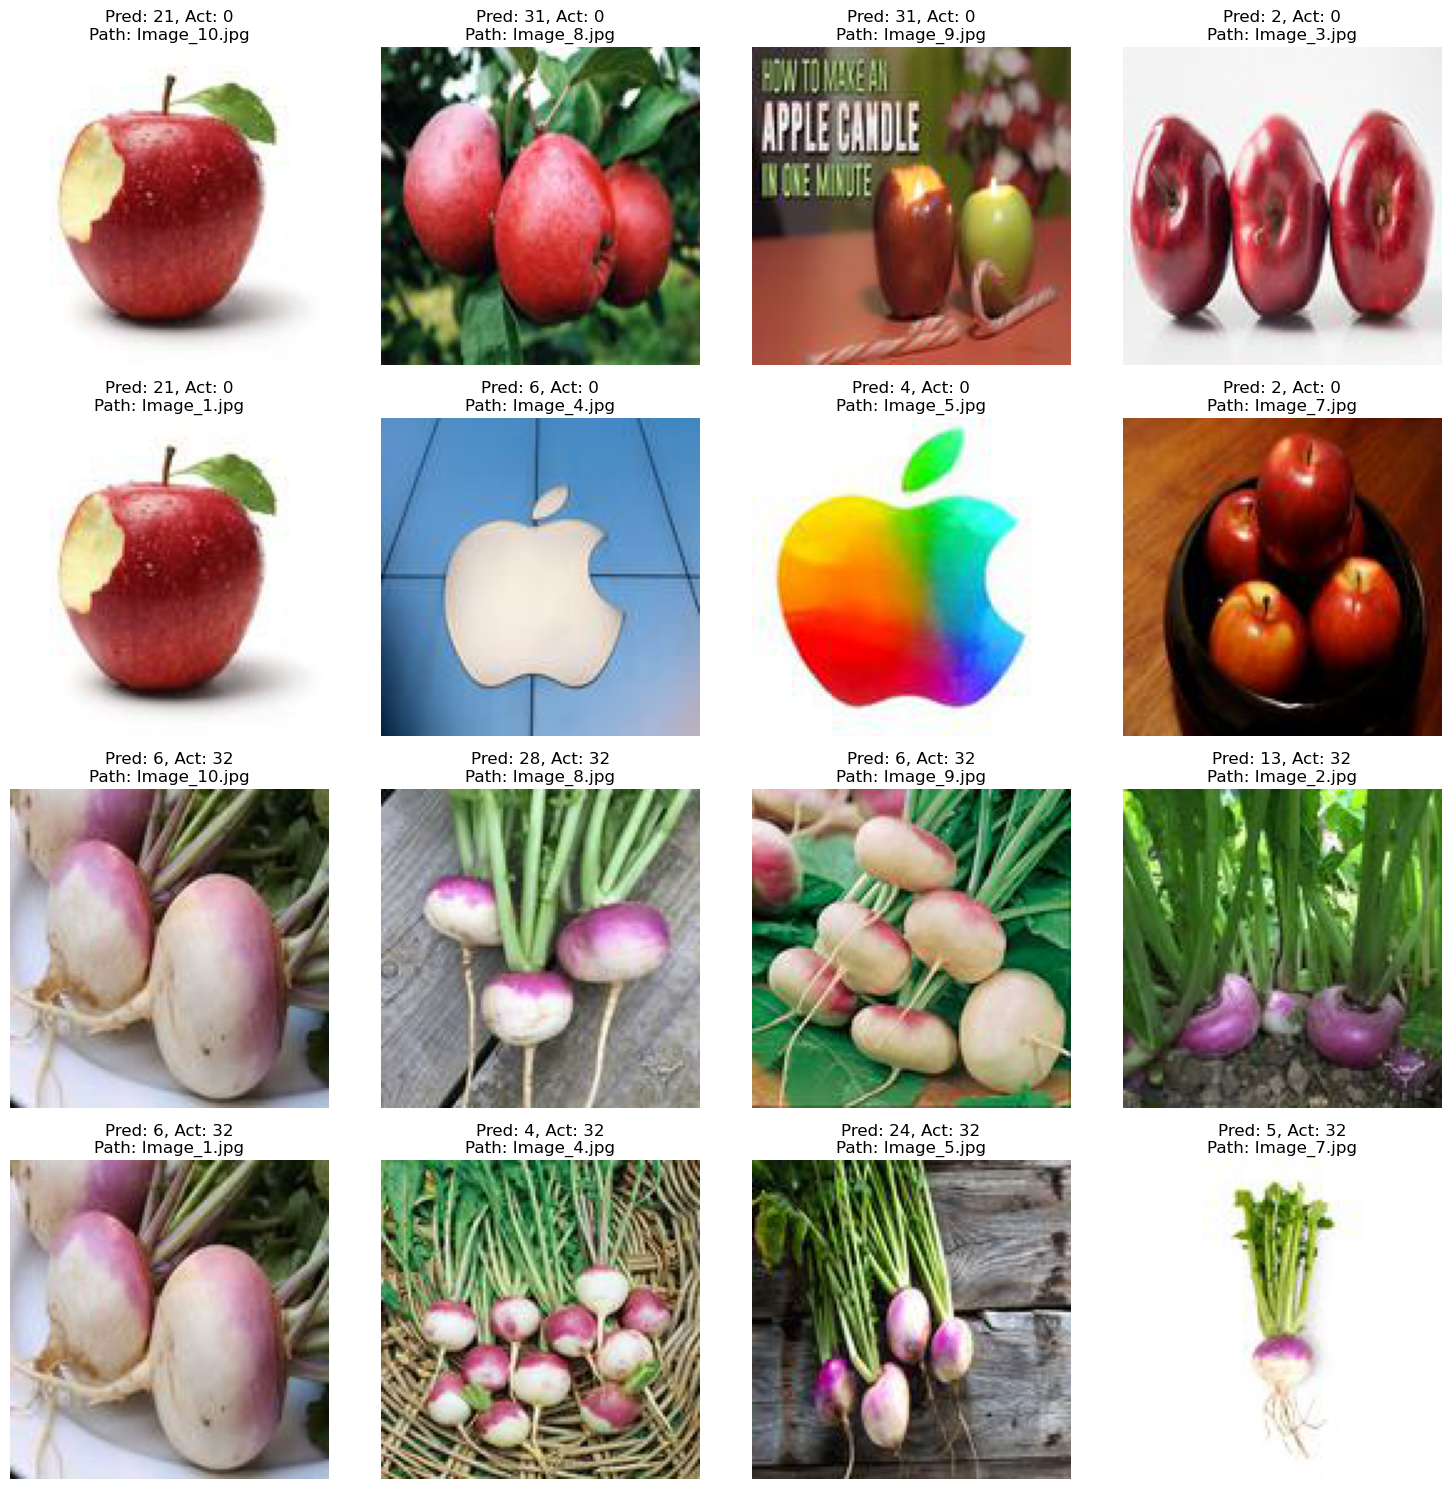

In [8]:
# Train and evaluate classifier on RGB data
print("RGB Results:")
print("Random Forest:")
val_acc, test_acc, misclassified_val, misclassified_test = train_and_evaluate(rf_clf, X_train_rgb, y_train_rgb_encoded, X_val_rgb, y_val_rgb_encoded, X_test_rgb, y_test_rgb_encoded, label_encoder)

print_misclassified_samples(X_test_rgb, y_test_rgb_encoded, rf_clf.predict(X_test_rgb), misclassified_test, filenames_test_rgb, "Random Forest RGB Test")


### Random Forest - StratifiedKFold

Misclassified Samples:
Index: 0, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_28.jpg, Predicted: 21, Actual: 0
Index: 1, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_16.jpg, Predicted: 19, Actual: 0
Index: 2, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_17.jpg, Predicted: 31, Actual: 0
Index: 4, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_10.jpg, Predicted: 26, Actual: 0
Index: 5, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_39.jpg, Predicted: 21, Actual: 0
Index: 7, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_62.jpg, Predicted: 29, Actual: 0
Index: 8, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_63.jpg, Predicted: 26, Actual: 0
Index: 9, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_61.jpg, Predicted: 25, Actual: 0
Index: 10, Filename: /Users/alexchilton/Downloads/working/train/apple/Image_48.jpg, Predicted: 33, Actual: 0
Inde

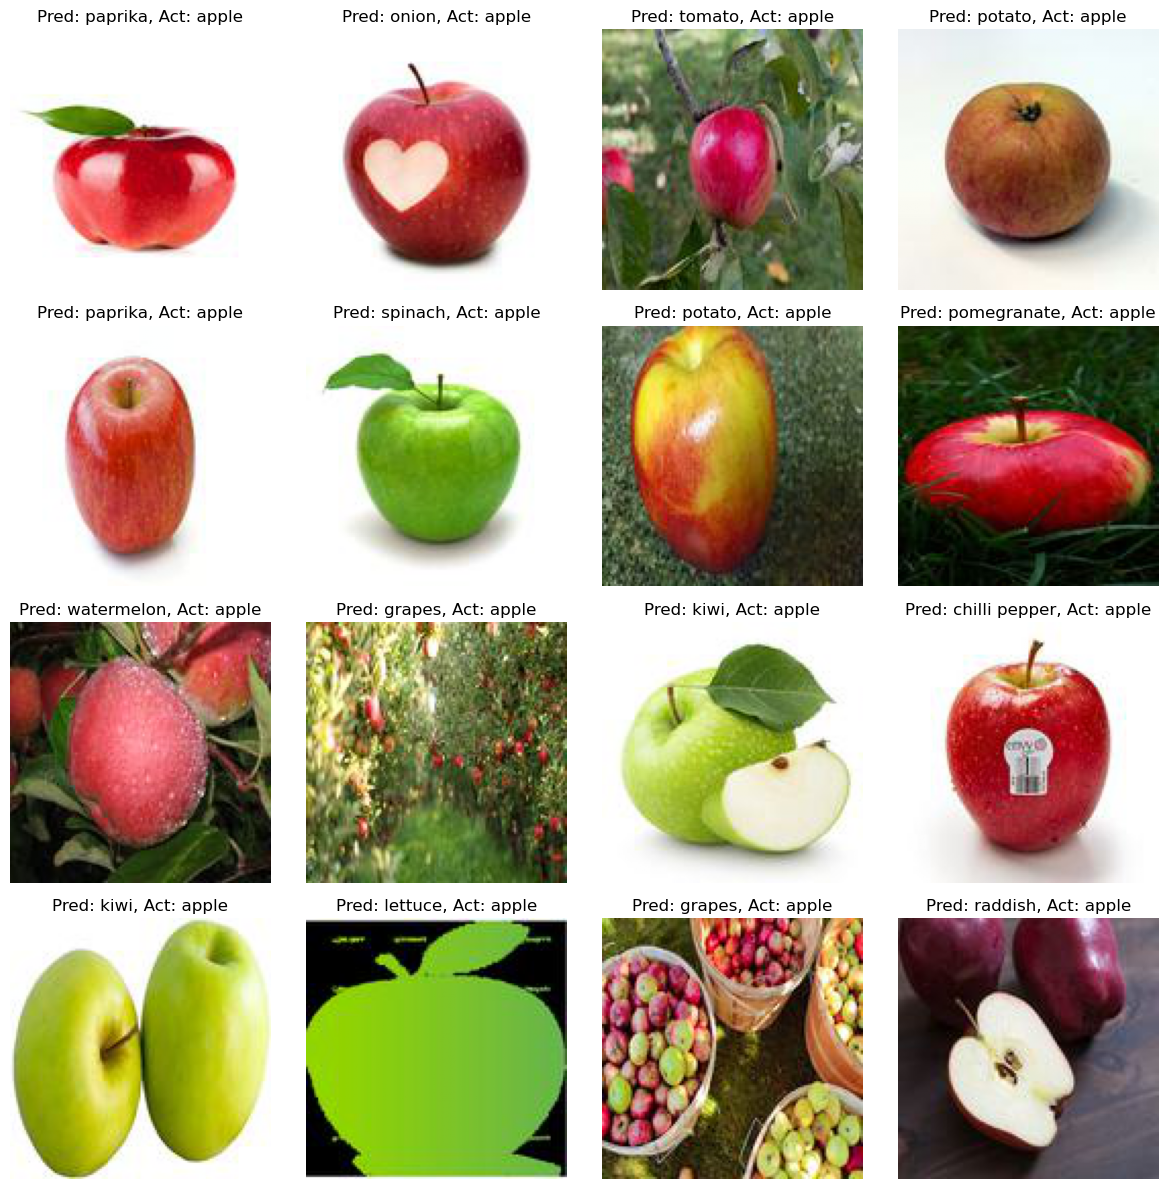

In [10]:
DIRS = [
    DIR_REAL_TRAIN,
    DIR_REAL_TEST,
    DIR_REAL_VALIDATION
]

# Load combined datasets
X, y ,filenames = load_images_from_folders(DIRS, exclude_classes=exclude_classes, grayscale=False)

# Normalize the image data to [0, 1]
X = X / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a pipeline with the classifier
pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))

# Use stratified cross-validation
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation and get scores
scores = cross_val_score(pipeline, X, y_encoded, cv=stratified_kf, scoring='accuracy')


# Perform cross-validation and get predictions
y_pred = cross_val_predict(pipeline, X, y_encoded, cv=5)

# Calculate overall accuracy
accuracy = accuracy_score(y_encoded, y_pred)

# Find misclassified samples
misclassified_indices = np.where(y_encoded != y_pred)[0]

# Print some misclassified samples
print("Misclassified Samples:")
for index in misclassified_indices[:10]:  # Print first 10 misclassified samples
    print(f"Index: {index}, Filename: {filenames[index]}, Predicted: {y_pred[index]}, Actual: {y_encoded[index]}")

# Plot some misclassified samples
num_samples = min(16, len(misclassified_indices))  # Plot up to 16 samples
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, index in zip(axes, misclassified_indices[:num_samples]):
    img = X[index].reshape(128, 128, 3)  # Reshape the flattened image
    ax.imshow(img)
    ax.set_title(f"Pred: {label_encoder.inverse_transform([y_pred[index]])[0]}, Act: {label_encoder.inverse_transform([y_encoded[index]])[0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Basic CNN implementation

### Data augmentation and preprocessing
without data augmentation i was getting around 53% accuracy

In [12]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Define paths
train_dir = DIR_REAL_TRAIN
test_dir = DIR_REAL_TEST

# Create an instance of the ImageDataGenerator with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Create an instance of the ImageDataGenerator for the test set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed= 777,
    target_size=(128, 128),
    batch_size=20,           # Number of images to yield per batch
    class_mode='categorical' # Since we have multiple classes
)
# Check data loading
for data_batch, labels_batch in train_generator:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break  # Only check the first batch
    
test_generator = test_datagen.flow_from_directory(
    test_dir,
    seed= 777,
    target_size=(128, 128),
    batch_size=20,
    class_mode='categorical'
)

Found 2112 images belonging to 34 classes.
Data batch shape: (20, 128, 128, 3)
Labels batch shape: (20, 34)
Found 339 images belonging to 34 classes.


### Create a simple CNN model

In [13]:
# Create a more complex CNN model with padding adjustments
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Second convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Third convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Fourth convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fifth convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.2),


    # Flattening the 3D output to 1D
    layers.Flatten(),

    # Fully connected (Dense) layer
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    #layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Output layer with softmax activation for classification
    layers.Dense(34, activation='softmax')
])

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Compile the model with a different optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Compile the model
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 637,634 (2.43 MB)

 Trainable params: 635,522 (2.42 MB)

 Non-trainable params: 2,112 (8.25 KB)

### Train the model

In [14]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    MODEL_LOCATION,  # Path where the model will be saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to determine the best model ('max' for validation accuracy)
    verbose=1  # Verbosity mode
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=test_generator,
    verbose=2,
    callbacks=[early_stopping,checkpoint_callback, reduce_lr]  # Include the callback
)

# Save the training history for later visualization
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/150

Epoch 1: val_accuracy improved from -inf to 0.03540, saving model to /Users/alexchilton/Downloads/working/best_model.keras
106/106 - 106s - 1s/step - accuracy: 0.0928 - loss: 3.4442 - val_accuracy: 0.0354 - val_loss: 4.4220 - learning_rate: 0.0010
Epoch 2/150

Epoch 2: val_accuracy improved from 0.03540 to 0.03835, saving model to /Users/alexchilton/Downloads/working/best_model.keras
106/106 - 103s - 974ms/step - accuracy: 0.1842 - loss: 2.8514 - val_accuracy: 0.0383 - val_loss: 4.3140 - learning_rate: 0.0010
Epoch 3/150

Epoch 3: val_accuracy improved from 0.03835 to 0.07080, saving model to /Users/alexchilton/Downloads/working/best_model.keras
106/106 - 80s - 751ms/step - accuracy: 0.2292 - loss: 2.6508 - val_accuracy: 0.0708 - val_loss: 3.8574 - learning_rate: 0.0010
Epoch 4/150

Epoch 4: val_accuracy improved from 0.07080 to 0.13569, saving model to /Users/alexchilton/Downloads/working/best_model.keras
106/106 - 83s - 784ms/step - accuracy: 0.2609 - loss: 2.4939 - val_

### Evaluate the model

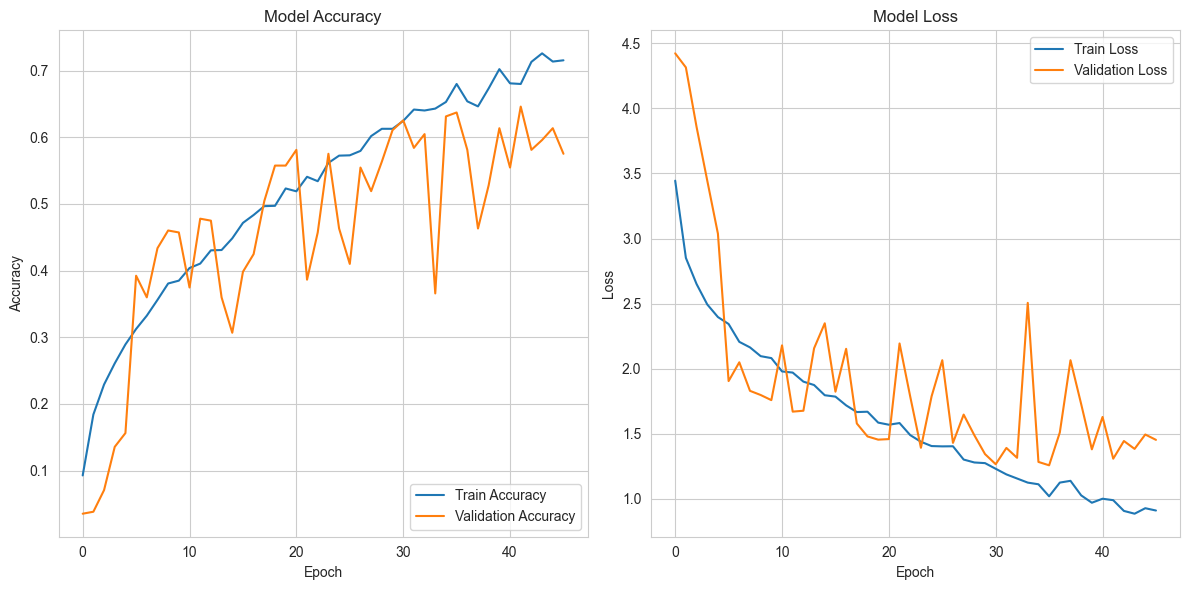

In [15]:
# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

### Predictions

In [16]:
# Initialize empty numpy arrays to store predicted classes and true labels
predictions = np.array([])
labels = np.array([])

# Reset the test generator to start from the first batch
test_generator.reset()

# Iterate through the test generator
for i in range(len(test_generator)):
    # Get the input data (x) and true labels (y)
    x, y = test_generator[i]

    # Use the model to predict the class probabilities of the input data
    predict_x = model.predict(x)

    # Convert the predicted probabilities to class predictions
    classes_x = np.argmax(predict_x, axis=1)

    # Add the predicted classes and true labels to the numpy arrays
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y, axis=1)])  # Convert one-hot to class indices

# Convert the numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

# Create a confusion matrix using the predicted classes and true labels
conf_matrix = confusion_matrix(labels, predictions, normalize='true')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


### Confusion matrix


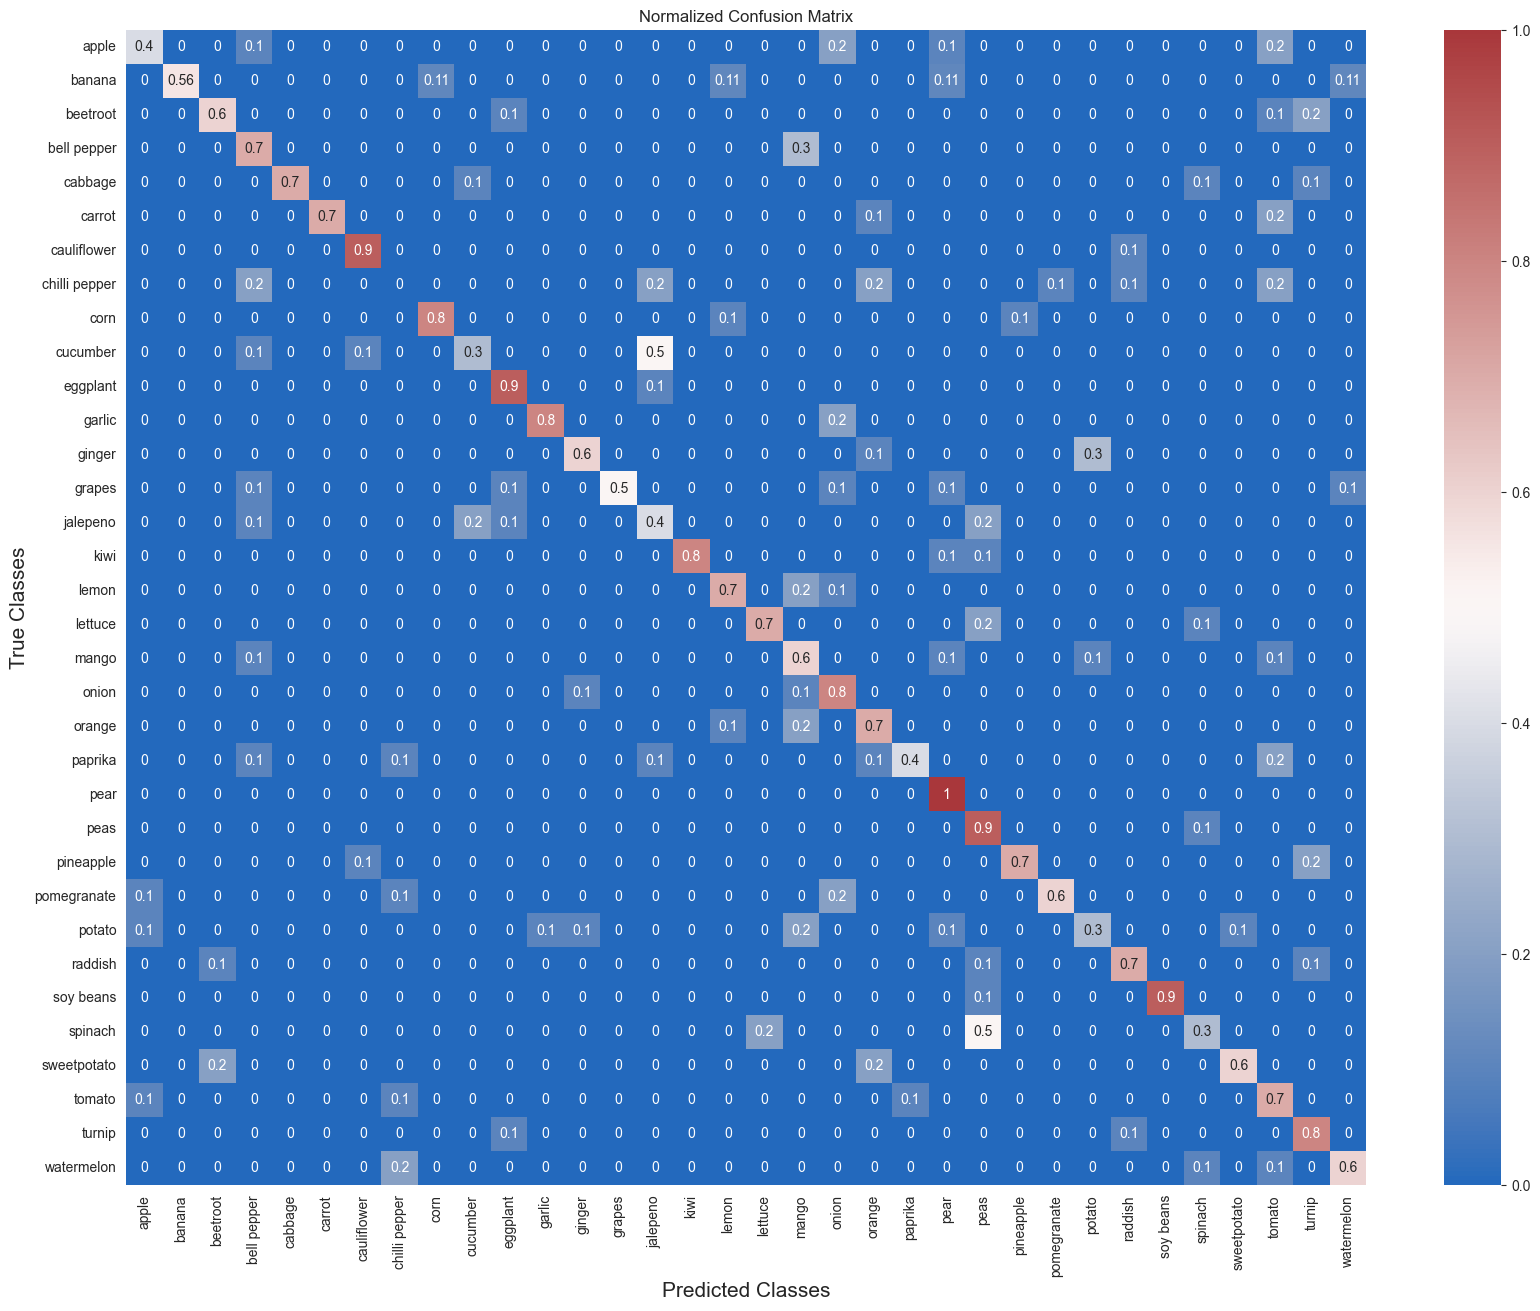

In [17]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix,
            cmap='vlag',
            annot=True,
            xticklabels=[label_names[x] for x in sorted(set(labels))],
            yticklabels=[label_names[x] for x in sorted(set(labels))])
plt.xlabel("Predicted Classes", fontsize=15)
plt.ylabel("True Classes", fontsize=15)
plt.title('Normalized Confusion Matrix')
plt.show()

### Classification report


In [18]:

# Convert numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

# Generate classification report
class_report = classification_report(labels, predictions, target_names=[label_names[i] for i in sorted(label_names.keys())])

print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

        apple       0.57      0.40      0.47        10
       banana       1.00      0.56      0.71         9
     beetroot       0.67      0.60      0.63        10
  bell pepper       0.47      0.70      0.56        10
      cabbage       1.00      0.70      0.82        10
       carrot       1.00      0.70      0.82        10
  cauliflower       0.82      0.90      0.86        10
chilli pepper       0.00      0.00      0.00        10
         corn       0.89      0.80      0.84        10
     cucumber       0.50      0.30      0.38        10
     eggplant       0.69      0.90      0.78        10
       garlic       0.89      0.80      0.84        10
       ginger       0.75      0.60      0.67        10
       grapes       1.00      0.50      0.67        10
     jalepeno       0.31      0.40      0.35        10
         kiwi       1.00      0.80      0.89        10
        lemon       0.70      0.70      0

In [ ]:
### Test the model with a few images and with some saved by the webcam app


In [19]:
# Load the trained model
model = tf.keras.models.load_model(MODEL_LOCATION)

# Define paths to the images
image_paths = [
    '/Users/alexchilton/Downloads/working/validation/apple/Image_23.jpg',
    '/Users/alexchilton/Downloads/working/validation/banana/Image_23.jpg',
    '/Users/alexchilton/Downloads/working/validation/orange/Image_13.jpg',
    '/Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_0.jpg',
    '/Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_1.jpg',
    '/Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_2.jpg',
    '/Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_3.jpg',
    '/Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_4.jpg'
]

# Predict and get true labels
predictions = []
true_labels = []

for img_path in image_paths:
    img_array = load_and_preprocess_image(img_path)
    pred_prob = model.predict(img_array)
    pred_class = np.argmax(pred_prob, axis=1)[0]  # Get the predicted class index
    predictions.append(pred_class)
    true_labels.append(get_true_label(img_path))  # Extract true label from image path

# Convert numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

print("Results:")
for i, img_path in enumerate(image_paths):
    pred_label = label_names[predictions[i]]
    true_label = true_labels[i]
    print(f"Image: {img_path}")
    print(f"Predicted Class: {pred_label}")
    print(f"True Class: {true_label}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Results:
Image: /Users/alexchilton/Downloads/working/validation/apple/Image_23.jpg
Predicted Class: apple
True Class: apple

Image: /Users/alexchilton/Downloads/working/validation/banana/Image_23.jpg
Predicted Class: garlic
True Class: banana

Image: /Users/alexchilton/Downloads/working/validation/orange/Image_13.jpg
Predicted Class: onion
True Class: orange

Image: /Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_0.jpg
Predicted Class: onion
True Class: processed_images

Image: /Users/alexchilton/DataspellProjects/CAS_Project2/processed_images/captured_image_1.jpg
Predicted Class: onion
True Class: processed_images

Image: /Users/alexchilton/DataspellPro

### Use the validation set

Found 340 images belonging to 34 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step
Index: 1, Image: apple/Image_24.jpg, Predicted: pear, Actual: apple


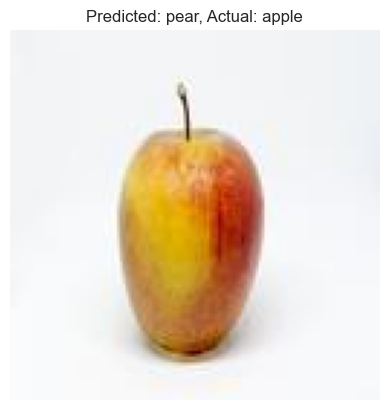

Index: 2, Image: apple/Image_43.jpg, Predicted: pomegranate, Actual: apple


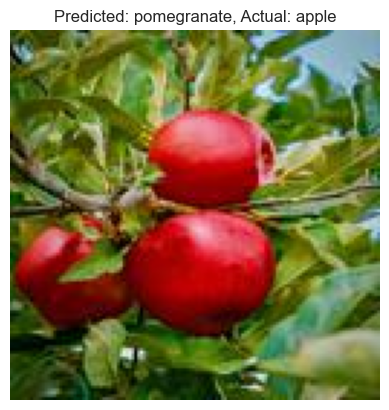

Index: 3, Image: apple/Image_47.jpg, Predicted: onion, Actual: apple


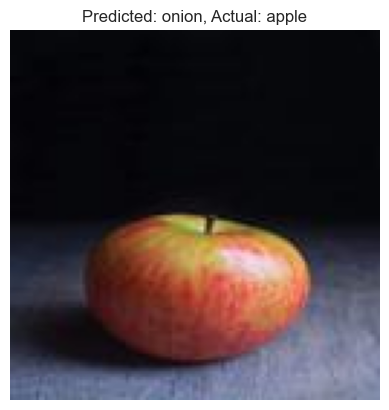

Index: 4, Image: apple/Image_49.jpg, Predicted: pear, Actual: apple


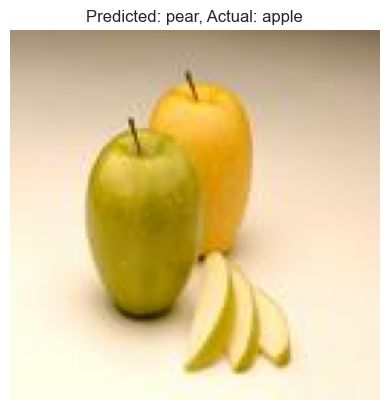

Index: 5, Image: apple/Image_51.jpg, Predicted: tomato, Actual: apple


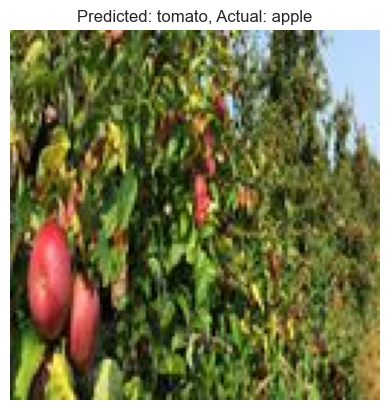

Index: 6, Image: apple/Image_55.jpg, Predicted: eggplant, Actual: apple


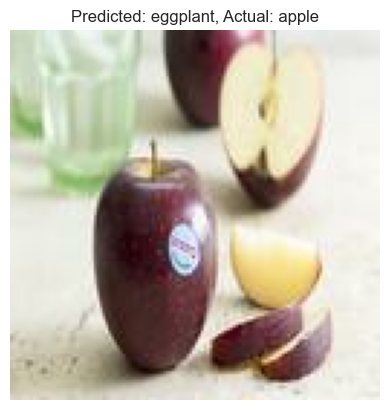

Index: 7, Image: apple/Image_78.jpg, Predicted: bell pepper, Actual: apple


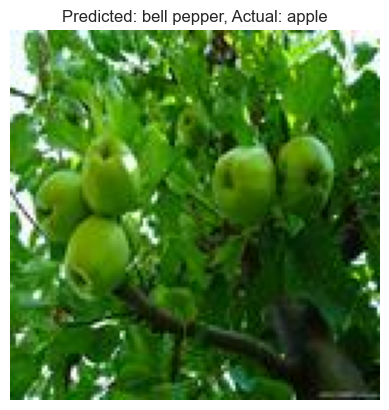

Index: 11, Image: banana/Image_23.jpg, Predicted: garlic, Actual: banana


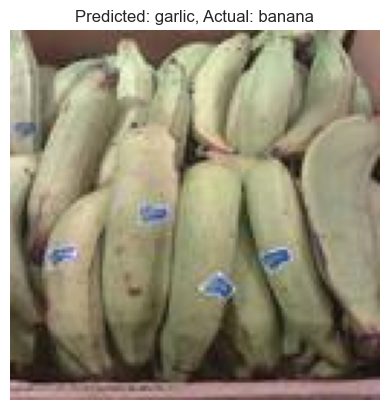

Index: 12, Image: banana/Image_24.jpg, Predicted: lemon, Actual: banana


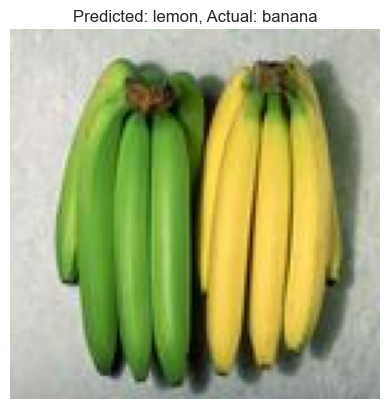

Index: 14, Image: banana/Image_56.jpg, Predicted: pear, Actual: banana
Validation Accuracy: 0.5118
Classification Report:
               precision    recall  f1-score   support

        apple       0.43      0.30      0.35        10
       banana       1.00      0.50      0.67        10
     beetroot       0.64      0.70      0.67        10
  bell pepper       0.36      0.50      0.42        10
      cabbage       0.75      0.60      0.67        10
       carrot       0.75      0.60      0.67        10
  cauliflower       0.62      0.80      0.70        10
chilli pepper       0.25      0.20      0.22        10
         corn       0.67      0.20      0.31        10
     cucumber       0.75      0.60      0.67        10
     eggplant       0.67      0.60      0.63        10
       garlic       0.55      0.60      0.57        10
       ginger       0.47      0.70      0.56        10
       grapes       0.75      0.90      0.82        10
     jalepeno       0.20      0.10      0.13        

In [20]:
# Load the trained model
model = tf.keras.models.load_model(MODEL_LOCATION)

# Define the paths to the validation set
val_dir = DIR_REAL_VALIDATION
# Create an ImageDataGenerator instance for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create the validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # Do not shuffle to ensure correct mapping of predictions to true labels
)

# Predict the classes for the validation set
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

mismatch_count = 0
# Iterate through the predictions and true labels
for i in range(len(predicted_classes)):
    if predicted_classes[i] != true_classes[i]:
        # Get the image file name from the file path
        image_name = val_generator.filenames[i]
        predicted_class = class_labels[predicted_classes[i]]
        actual_class = class_labels[true_classes[i]]
        print(f"Index: {i}, Image: {image_name}, Predicted: {predicted_class}, Actual: {actual_class}")

        # Increment the mismatch counter
        mismatch_count += 1

        # Break the loop after showing the first 10 mismatches
        if mismatch_count >= 10:
            break
            
        # Load and plot the image
        img_path = os.path.join(val_dir, image_name)
        if not img_path.lower().endswith('.png'):
            img = mpimg.imread(img_path)

            plt.figure()
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}")
            plt.axis('off')
            plt.show()
        

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


### Saliency Maps 
- to try and show whats happening

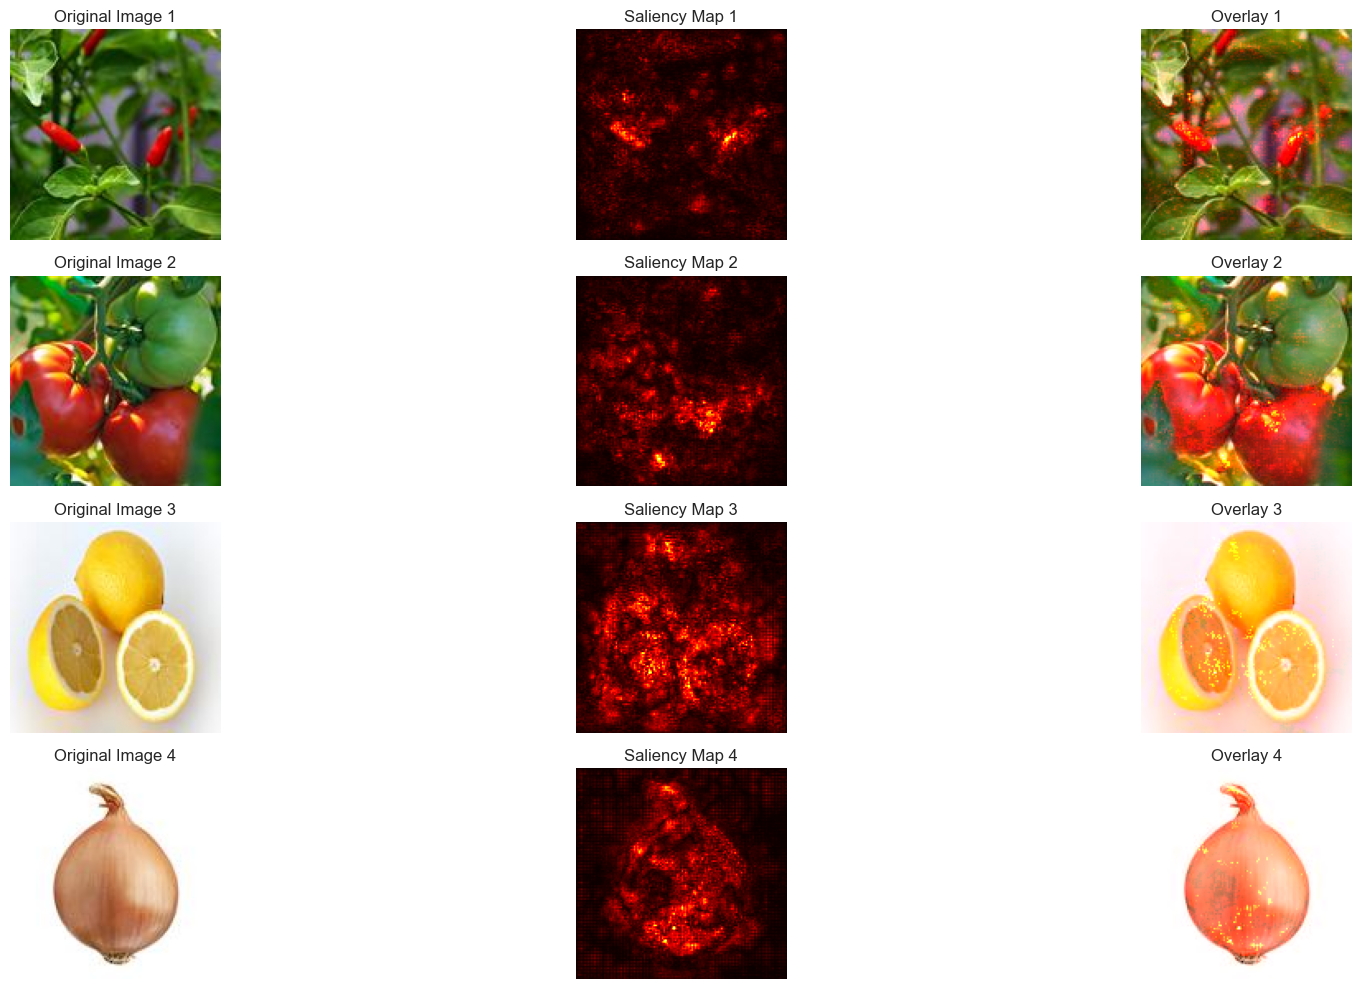

In [21]:
# Load the best model
model = tf.keras.models.load_model(MODEL_LOCATION)

# List of image paths
img_paths = [
    '/Users/alexchilton/Downloads/working/train/chilli pepper/Image_36.jpg',
    '/Users/alexchilton/Downloads/working/train/tomato/Image_8.jpg',
    '/Users/alexchilton/Downloads/working/train/lemon/Image_11.jpg',
    '/Users/alexchilton/Downloads/working/train/onion/Image_26.jpg'
]

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale like in your generator
    return img_array

# Function to compute saliency map
def compute_saliency_map(model, img_array):
    img_array = tf.convert_to_tensor(img_array)  # Convert NumPy array to TensorFlow tensor
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        top_pred_idx = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_idx]

    # Get the gradient of the loss with respect to the input image
    grads = tape.gradient(top_class_channel, img_array)
    
    # Take the maximum of the gradients along the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency = saliency.numpy()
    
    return saliency

# Function to overlay saliency map on the original image
def overlay_saliency_on_image(img_path, saliency_map):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalize image array

    # Normalize saliency map
    saliency_map = np.interp(saliency_map[0], (saliency_map[0].min(), saliency_map[0].max()), (0, 1))
    
    # Create an overlay
    heatmap = cm.get_cmap('hot')(saliency_map)
    heatmap = heatmap[:, :, :3]  # Remove alpha channel
    overlay = np.clip(img_array + heatmap, 0, 1)
    
    return img_array, overlay

# Function to display images with overlays
def display_images_with_overlays(img_paths, saliency_maps):
    plt.figure(figsize=(20, 10))

    for i, (img_path, saliency_map) in enumerate(zip(img_paths, saliency_maps)):
        img_array, overlay = overlay_saliency_on_image(img_path, saliency_map)
        
        # Display original image
        plt.subplot(len(img_paths), 3, 3 * i + 1)
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f'Original Image {i+1}')
        
        # Display saliency map
        plt.subplot(len(img_paths), 3, 3 * i + 2)
        plt.imshow(saliency_map[0], cmap='hot')
        plt.axis('off')
        plt.title(f'Saliency Map {i+1}')
        
        # Display image with saliency overlay
        plt.subplot(len(img_paths), 3, 3 * i + 3)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f'Overlay {i+1}')

    plt.tight_layout()
    plt.show()

# Process and compute saliency maps for all images
saliency_maps = [compute_saliency_map(model, preprocess_image(img_path)) for img_path in img_paths]

# Display images with saliency overlays
display_images_with_overlays(img_paths, saliency_maps)
